

## Prevenção de Suicídio
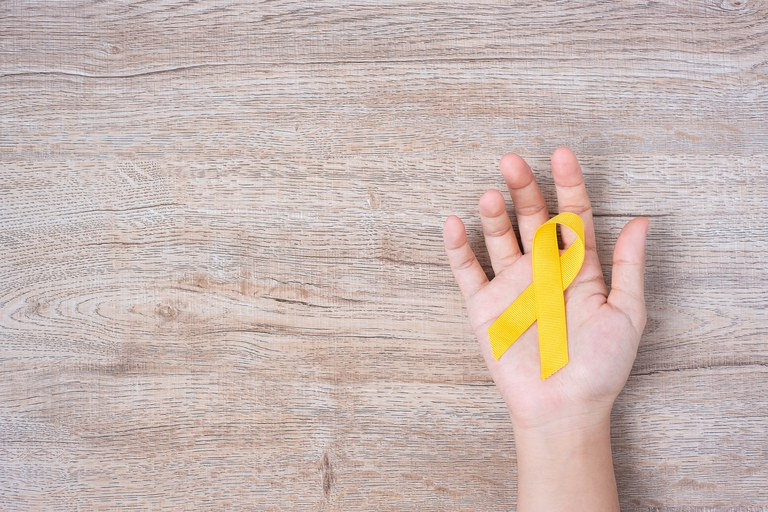

## Definição do Projeto


### Porque é importante prever o suicídio?


Segundo a OMS, o suicídio é a 3ª causa de morte de jovens brasileiros entre 15 e 29 anos. No Brasil, cerca de 12 mil pessoas tiram a própria vida por ano, quase 6% da população. No mundo, são cerca de 800 mil de suicídios anuais. O Brasil só perde para os EUA.

No mundo, as notificações apontam para um suicídio a cada 40 segundos. No Brasil, a cada 46 minutos, uma realidade devastadora quando se identifica o perfil das vítimas brasileiras: a maioria é homem, negro, com idade entre 10 e 29 anos, segundo dados do Ministério da Saúde. Na Bahia, entre 2010 e 2019, foram contabilizados 8.833 casos de lesões autoprovocadas e, destes, 5.160 foram casos de suicídio. 

Fonte:
http://www.saude.ba.gov.br/2020/09/10/oms-alerta-suicidio-e-a-3a-causa-de-morte-de-jovens-brasileiros-entre-15-e-29-anos/

Alguns dados sobre suicídio fornecidos pela Organização Mundial de Saúde:
* Quase 800.000 pessoas morrem por suicídio todos os anos. Além disso, para cada suicídio, ocorrem mais de 20 tentativas de suicídio.
* Suicídios e tentativas de suicídio têm um efeito cascata que afeta famílias, amigos, colegas, comunidades e sociedades.
* Os suicídios são evitáveis. Muito pode ser feito para prevenir o suicídio em nível individual, comunitário e nacional.

Algumas estatísticas sobre suicídio no Brasil: 
* A  maioria  dos  registros  de  suicídio  no  Brasil  entre  2010  e  2019  foram  de  pessoas solteiras (54,46%).
* Os  meses  de  Dezembro,  Outubro  e  Março,  respectivamente,  contam  com  o  maior número de casos de suicídio.
* A média de suicídios ao longo de 2010 e 2019, por ano, é de 11249. De modo geral, o número bruto de suicídios vem aumentando ao longo dos anos.-O local mais comum para ocorrência do suicídio é no domicílio (60,89% dos casos).
* A maioria dos casos de suicídio não recebeu assistência médica preventiva.

Neste mini-projeto trabalharei com um tema relevante para a sociedade e ao mesmo tempo demonstrarei minhas habilidades em Machine Learning estudadas no curso.





## Dataset

Para essa tarefa, usarei um conjunto de dados disponibilizado publicamente no Kaggle [dataset](https://www.kaggle.com/nikhileswarkomati/suicide-watch), extraido de postagens dos subreddits "SuicideWatch" e "depression" da plataforma Reddit. O Reddit é uma plataforma preferida por pessoas com problemas emocionais, por isso fornece pistas significativas para o suicídio.

As postagens foram coletadas usando a API Pushshift. Todas as postagens feitas para "SuicideWatch" foram coletadas de 16 de dezembro de 2008 (criação) até 2 de janeiro de 2021 , enquanto as postagens de "depression" foram coletadas de 1 de janeiro de 2009 a 2 de janeiro de 2021.

Créditos para Nikhileswar Komati por coletar e disponibilizar as informações na plataforma Kaggle.

#### Obs.: A fonte de dados já está previamente balanceada.
  
Um exemplo de post categorizado como suicídio:

'I've become so accustomed to the fact that I'm going to kill myself that other people's struggles with suicide don't register to me muchBecause I think about it so much I just see them as another person like me. It also makes me feel like everyone is like me, so if I went to kill myself and people were around nobody would care.'

Usaremos 116037 postagens de cada categoria (suicide, non-suicide). Nosso vocabulário será de tamanho 5.500. Além disso, cada documento será representado por uma tag - para fins de visualização. Por exemplo, o 50º documento classificado com suicídio será representado como suicídio-50.


Usaremos a seguinte estratégia:

1. Extrair os dados dos textos das postegens e aprender as word embeddings.
2. Extrair conjuntos randômicos de documentos dos word embeddings já treinados.
3. Preparar os dados para os modelos de treinamento e avaliação doc2Vec
4. Construir o vocabulário através de um modelo doc2vec - Distributed Bag of Words (DBOW)
5. Aplicar um modelo de Regressão Logística para classificação
6. Apresentar ao modelo dados não envolvidos no processo de treinamento e teste para validar a capacidade do modelo classificar corretamente as postagens.

## Carregando os Dados

In [1]:
# Imports

import pandas as pd
import os
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud
from IPython.display import Image
import collections
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report, accuracy_score, roc_curve, auc, precision_score, recall_score, roc_auc_score 
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from tqdm import tqdm
from sklearn import utils
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Carregando o Dataset
Suicide_Detection = pd.read_csv('../input/suicide-watch/Suicide_Detection.csv')

In [3]:
Suicide_Detection.shape

(232074, 3)

### Explorando os dados

In [4]:
Suicide_Detection

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide
...,...,...,...
232069,348103,If you don't like rock then your not going to ...,non-suicide
232070,348106,You how you can tell i have so many friends an...,non-suicide
232071,348107,pee probably tastes like salty tea😏💦‼️ can som...,non-suicide
232072,348108,The usual stuff you find hereI'm not posting t...,suicide


In [5]:
print(Suicide_Detection.groupby(['class'])['class'].count())

class
non-suicide    116037
suicide        116037
Name: class, dtype: int64


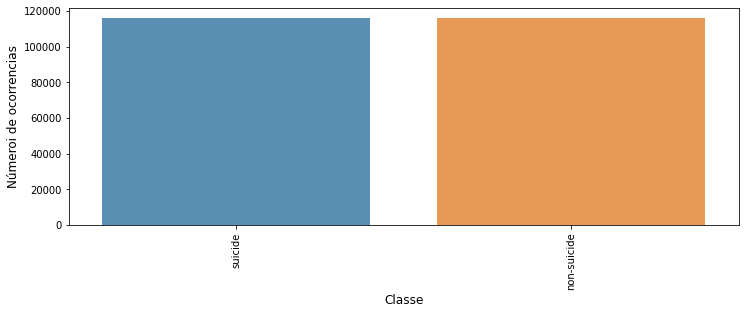

In [6]:
topic = Suicide_Detection['class'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(topic.index, topic.values, alpha=0.8)
plt.ylabel('Númeroi de ocorrencias', fontsize=12)
plt.xlabel('Classe', fontsize=12)
plt.xticks(rotation=90)
plt.show();

In [7]:
# Verificando a quantidade de palavras existentes no conjunto de dados
Suicide_Detection['text'].apply(lambda x: len(x.split(' '))).sum()

30528508

Temos mais de 30 milhões de palavras, trata-se de um conjunto de dados relativamente grande.

In [8]:
# Criando variáveis auxiliares para exploração dos dados
Suicide_Detection['post_len'] = Suicide_Detection['text'].astype(str).apply(len)
Suicide_Detection['word_count'] = Suicide_Detection['text'].apply(lambda x: len(str(x).split()))

### Visualizando a distribuição do comprimento do texto das Postagens

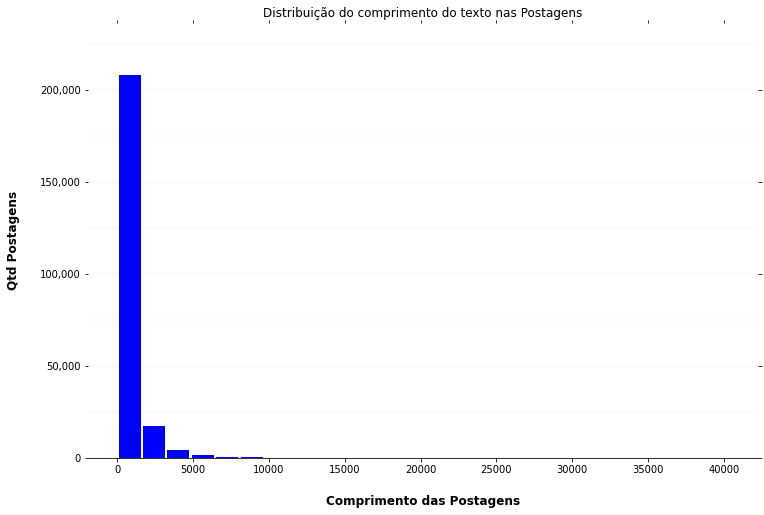

In [9]:
ax = Suicide_Detection.hist(column='post_len', bins=25, grid=False, figsize=(12,8), color='blue', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # title
    x.set_title("Distribuição do comprimento do texto nas Postagens")

    # Set x-axis label
    x.set_xlabel("Comprimento das Postagens", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Qtd Postagens", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,g}'))

### Visualizando a distribuição da contagem de palavras das Postagens

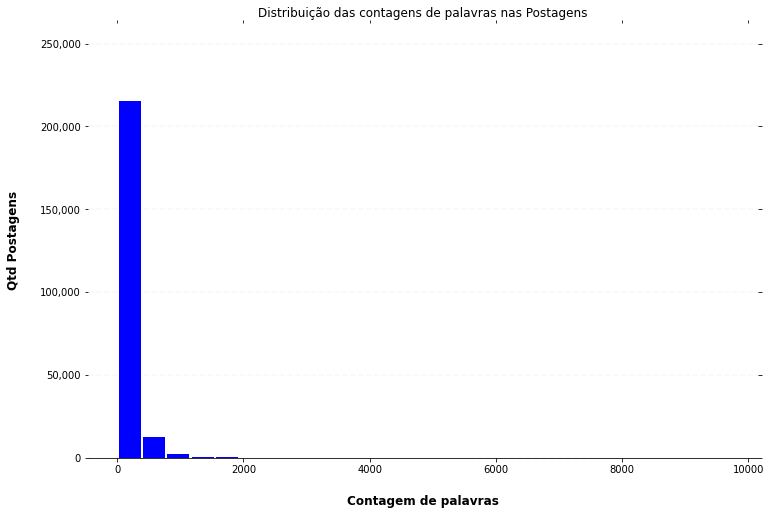

In [10]:
ax = Suicide_Detection.hist(column='word_count', bins=25, grid=False, figsize=(12,8), color='blue', zorder=2, rwidth=0.9)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")

    # Draw horizontal axis lines
    vals = x.get_yticks()
    for tick in vals:
        x.axhline(y=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

    # title
    x.set_title("Distribuição das contagens de palavras nas Postagens")

    # Set x-axis label
    x.set_xlabel("Contagem de palavras", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Qtd Postagens", labelpad=20, weight='bold', size=12)

    # Format y-axis label
    x.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,g}'))

A maiorias das postagens possuem até mais ou menos 1600 caracteres, com até mais ou menos 400 palavras.

### Visualizando a Nuvem de Palavras das Postagens

Nuvens de palavras são representações gráficas da frequência das palavras que dão maior destaque às palavras que aparecem com mais frequência em um texto de origem. Quanto maior a palavra no visual, mais comum ela é no (s) texto (s). Esse tipo de visualização pode ajudar os avaliadores com análise textual exploratória, identificando palavras que aparecem com frequência em um conjunto de entrevistas, documentos ou texto. Também pode ser usado para comunicar os pontos ou temas mais salientes no estágio de relatório.

In [11]:
stop_words = set(stopwords.words('english'))
posts = Suicide_Detection['text']
posts = [w for w in posts if not w in stop_words]
all_posts = " ".join(p for p in posts)

In [12]:
wordcloud = WordCloud(background_color='black', width=1600,                            
                      height=800, max_words=400).generate(all_posts)

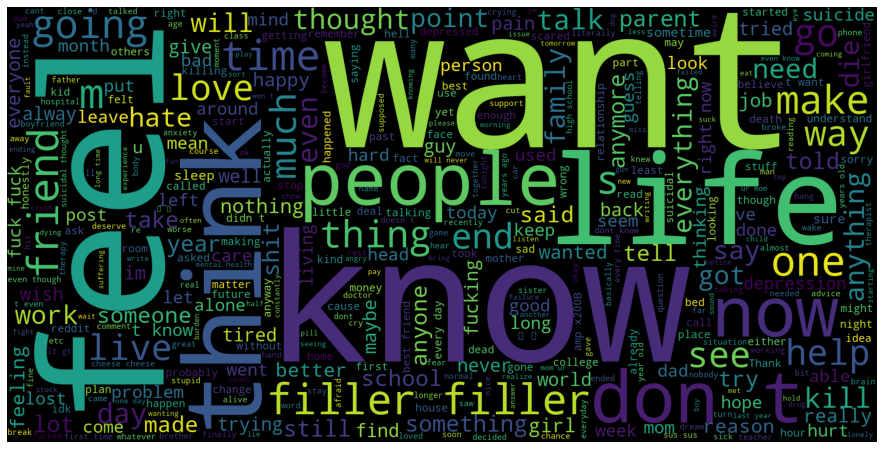

In [13]:
fig, ax = plt.subplots(figsize=(16,8))            
ax.imshow(wordcloud, interpolation='bilinear')       
ax.set_axis_off()
plt.imshow(wordcloud)  

## Engenharia de Atributos

In [14]:
# Eliminando informações que não serão utilizadas no processo de treinamento do modelo
Suicide_Detection.drop(columns = ["Unnamed: 0", "post_len", "word_count"], inplace=True)

In [15]:
labels = Suicide_Detection['class'].values

In [16]:
# Definindo as percventagens de dados de treino, teste e validação
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

In [17]:
# Diivisão dos dados em treino e teste
dados_treino, dados_teste = train_test_split(Suicide_Detection,                                  
                                             test_size = 1 - train_ratio, 
                                             random_state = 43, stratify=labels)

In [18]:
# Os dados de validação estará representado por 15% do conjunto de dados inicial
dados_validacao, dados_teste = train_test_split(dados_teste, test_size=test_ratio/(test_ratio + validation_ratio),
                                                random_state = 43) 

In [19]:
dados_teste.head(10)

,text,class
117065,I would pay all my money to hire someone to ki...,suicide
43317,The cowards way outPeople talk about suicide l...,suicide
19684,If I have a kid and they come out as Croatian ...,non-suicide
120617,Which youtube channel do you believe produces ...,non-suicide
28821,Almost got hit by a fucking milk truck So i wa...,non-suicide
223617,Thanks 2020I just got back from vacation to fi...,suicide
183675,I think thats itI (19m) was supposed to do it ...,suicide
22440,"I'm worried about what will happen to my dog, ...",suicide
207735,"I get this sort of way, this depressed, misera...",suicide
231816,Tutor thinks he is more important than grandma...,non-suicide


### Lendo os dados com pré-processamento utilizando a biblioteca NLTK

Agora vamos efetuar a leitura dos dados, converter o texto para letras minúscula, remoção de contrações e depois converter em tokens usando a biblioteca nltk. Temos duas funções read_data para montar os dados de treino e read_test_data para montar os dados de teste.

In [20]:
import re

contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                    "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", 
                    "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", 
                    "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  
                    "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", 
                    "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have",
                    "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                    "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                    "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
                    "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                    "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
                    "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
                    "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                    "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is",
                    "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", 
                    "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", 
                    "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", 
                    "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", 
                    "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", 
                    "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", 
                    "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", 
                    "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", 
                    "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", 
                    "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                    "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", 
                    "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", 
                    "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)
def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)

In [21]:
def read_data(filename):
    """
    Extrai as postagnes dos dados de treino e efetua o pré-processamento usando a biblioteca nltk python
    
    """
    data  = [[],[]] 
    train_data = {}
    for i in  tqdm(range(filename.shape[0])):
        text_string = filename[i, 0]
        text_string = text_string.lower()
        """ Limpeza do texto"""
        text_string = ''.join(c for c in text_string if not c.isdigit())
        text_string = replace_contractions(text_string)
        """tokenize"""
        tokenizer = RegexpTokenizer(r'\w+')
        text_string = tokenizer.tokenize(text_string)
        # Atribui a classe aos arquivos
        """ Elimina Sporwords """
        text_string  = [w for w in text_string if not w in stop_words]
        
        data[0].append(text_string)
        data[1].append(filename[i, 1])
        
        train_data[str(filename[i, 1])+'_'+str(i)] = text_string
    print('\tConcluída a leitura de dados treino') 
               
    return data, train_data

def read_test_data(filename):
    """
    Extrai as postagens dos dados de teste e efetua o pré-processamento usando a biblioteca nltk python
    """
    test_data = {}
    for i in  tqdm(range(filename.shape[0])):
        text_string = filename[i, 0]
        text_string = text_string.lower()
        """ Limpeza do texto"""
        text_string = ''.join(c for c in text_string if not c.isdigit())
        text_string = replace_contractions(text_string) 
        tokenizer = RegexpTokenizer(r'\w+')
        text_string = tokenizer.tokenize(text_string)
        # Atribui a classe aos arquivos
        """ Atribui a relação ao documento """
        test_data[str(filename[i, 1])+'_'+str(i)] = text_string
    print('\tConcluída a leitura de dados teste') 
               
    return test_data

print('Processando dados de treinamento...\n')
words, train_words = read_data(np.array(dados_treino))

print('\nProcessando dados de teste...\n')

test_words = read_test_data(np.array(dados_teste))

  0%|          | 161/162451 [00:00<01:40, 1609.59it/s]

Processando dados de treinamento...



  1%|          | 214/34812 [00:00<00:16, 2129.89it/s]

	Concluída a leitura de dados treino

Processando dados de teste...



100%|██████████| 34812/34812 [00:12<00:00, 2753.17it/s]

	Concluída a leitura de dados teste


### Construindo os Dicionários
Para entender cada um desses elementos, vamos também assumir o texto "Eu gosto de ir à escola"

* `dictionary`: mapeia uma palavra para um ID (i.e. {Eu:0, gosto:1, de:2, ir:3, à:4, escola:5})
* `reverse_dictionary`: mapeia um ID para uma palavra (i.e. {0:Eu, 1:gosto, 2:de, 3:ir, 4:à, 5:escola}
* `count`: Lista de elementos (palavra, frequência) (i.e. [(Eu,1),(gosto,1),(de,2),(ir,1),(à,1),(escola,1)]
* `data` : Contém a string de texto que lemos, onde palavras são substituídas por IDs de palavras (i.e. [0, 1, 2, 3, 2, 4])

Também introduzimos um token especial adicional chamado `UNK` para indicar que palavras raras são muito raras para serem usadas.

In [22]:
vocabulary_size = 5500
Words  = []
def build_dataset(words):
    for word in words[0]:
        Words.extend(word)  
    count = [['UNK', -1]]
    count.extend(collections.Counter(Words).most_common(vocabulary_size - 1))
    # Dicionário das sentenças
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    
    data = list()
    unk_count = 0
    for word in Words:
        if  word in dictionary:            
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']            
            unk_count = unk_count + 1
            
        data.append(word)

    count[0][1] = unk_count
    assert len(dictionary) == vocabulary_size

    return data, count, dictionary

def build_dataset_with_existing_dictionary(words, dictionary):
    '''
    Aqui usamos essa função para converter strings de palavras em IDs com um determinado dicionário
    '''
    data = list()
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
        data.append(word)
    return data

# Processando dados de treino
data, count, dictionary = build_dataset(words)

train_data = {}

print('Construindo o dataset de treino para o documento\n')
for k,v in tqdm(train_words.items()):
    train_data[k] = build_dataset_with_existing_dictionary(train_words[k],dictionary)

# Processando dados de teste

test_data = {}

print('Construindo o dataset de teste para o documento\n')
for k,v in tqdm(test_words.items()):
    test_data[k] = build_dataset_with_existing_dictionary(test_words[k],dictionary)
    
print('\nPalavras mais comuns (+UNK)', count[:5])
print('\nAmostra de dados', data[:10])
#print('\nChaves: ', test_data.keys())
#print('\nItems: ', test_data.items())

# Removemos para liberar memória no computador, pois não precisamos mais desses objetos. Manterei apenas o dicionário 
del words  
del data
del count
#del dictionary

  0%|          | 0/162451 [00:00<?, ?it/s]

Construindo o dataset de treino para o documento



  9%|▊         | 3001/34812 [00:00<00:01, 29963.74it/s]

Construindo o dataset de teste para o documento



100%|██████████| 34812/34812 [00:02<00:00, 15495.63it/s]



Palavras mais comuns (+UNK) [['UNK', 732695], ('like', 127154), ('want', 104530), ('know', 92177), ('feel', 85942)]

Amostra de dados ['moved', 'husbands', 'job', 'left', 'everything', 'behind', 'slowly', 'slipping', 'away', 'moved']


## Modelos de Treinamento e Avaliação doc2Vec


Doc2vec é um algoritmo não supervisionado para gerar vetores para frases, parágrafos ou documentos (Representações distribuídas de sentenças e documento). Trata-se de um conceito que foi apresentado em 2014 por Le & Mikilov, veja neste [artigo](https://arxiv.org/abs/1405.4053). Este algoritmo é uma adaptação do word2vec, sendo que os vetores gerados pelo doc2vec podem ser usados para tarefas como encontrar semelhanças entre sentenças , parágrafos ou documentos.

Um vetor de documento é uma representação abstrata de comprimento variável do significado contextual de um determinado tipo de documento. Assim como um vetor de palavras, é o produto do processo de treinamento para uma rede neural, onde a entrada é tipicamente um termo one-hot encoded codificado a partir do vocabulário do modelo e a saída é uma distribuição de probabilidade para palavras na próxima janela de contexto. 

Primeiramente instanciamos um modelo doc2vec - Distributed Bag of Words (DBOW). Na arquitetura word2vec, nós temos os algoritmos  “continuous bag of words” (CBOW) e “skip-gram” (SG), já na arquitetura doc2vec, os algoritmos correspondentes são “distributed memory” (DM) e “distributed bag of words” (DBOW).

O DBOW é o modelo doc2vec análogo ao modelo Skip-gram do word2vec. Os vetores de parágrafos são obtidos pelo treinamento de uma rede neural na tarefa de prever uma distribuição de probabilidade de palavras em um parágrafo, dada uma palavra aleatoriamente amostrada do parágrafo.

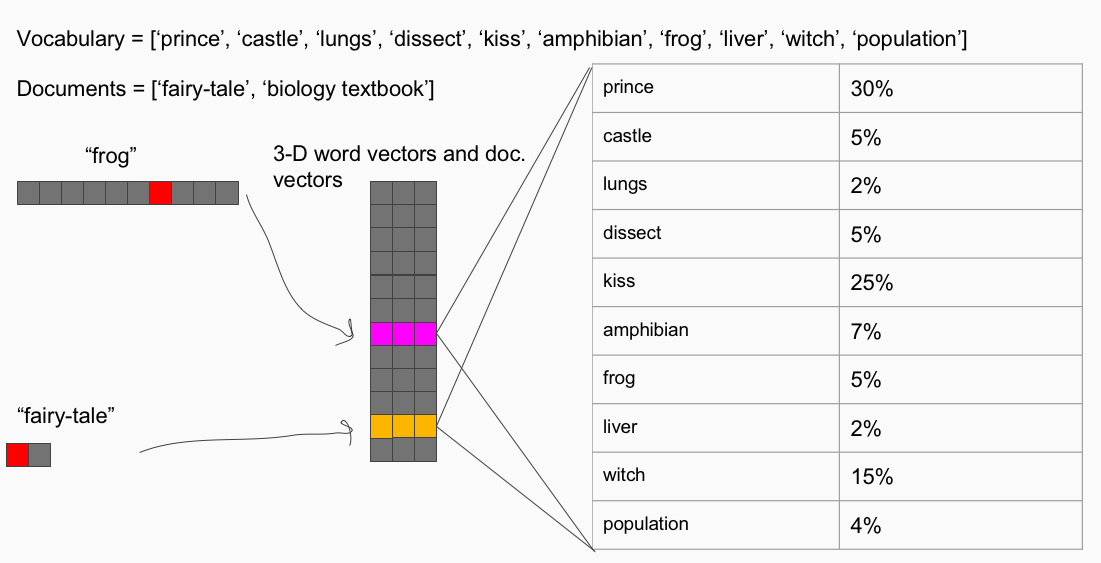

## Preparação dos dados para criação do vocabulário no doc2vec

In [23]:
# Converte de Dicionário para lista
data_train = [ [k,v] for k, v in train_data.items() ]
data_train = np.array(data_train)
data_test = [ [k,v] for k, v in test_data.items() ]
data_test = np.array(data_test)

In [24]:
# função para Identificar as classes dos documentos e preparando os dados para o algoritimo
def prepara_dados(data):
    datax = [[],[]]
    for x in range(data.shape[0]):
        s = data[x][0]
        s = s.split("_")
        datax[0].append(s[0])
        datax[1].append(data[x][1])                
    return datax

data_train = prepara_dados(data_train)
data_test = prepara_dados(data_test)

In [25]:
def label_sentences(corpus, topics):
    """
    A implementação do Doc2Vec da Gensim exige que cada documento / parágrafo tenha um rótulo associado a ele.
    Fiz isso usando o método TaggedDocument, etiquetando com a própria classe do documento.
    """
   
    labeled = []
    tags = np.unique(topics, return_counts=False)
    for i, v in enumerate(corpus):
        label = [s for s in tags if topics[i] in s and len(s) == len(topics[i])]
        doc =  " ".join(str(x) for x in v)
        labeled.append(TaggedDocument(doc.split(), label))
    return labeled
X_train = label_sentences(data_train[1], data_train[0])
X_test  = label_sentences(data_test[1], data_test[0])

In [26]:
X_test[1]

TaggedDocument(words=['the', 'cowards', 'way', 'outpeople', 'talk', 'about', 'suicide', 'like', 'it', 's', 'the', 'cowards', 'way', 'out', 'but', 'i', 'challenge', 'you', 'to', 'stare', 'into', 'the', 'abyss', 'with', 'no', 'clue', 'what', 's', 'down', 'there', 'and', 'no', 'way', 'back', 'out', 'that', 's', 'no', 'cowards', 'way', 'out', 'in', 'my', 'book'], tags=['suicide'])

In [27]:
len(X_train)

162451

In [28]:
len(X_test)

34812

In [29]:
# Instanciando um modelo Doc2Vec com um vetor de 128 palavras

model_dbow = Doc2Vec(dm=0, vector_size=128, window=10, negative=5, cbow_mean=1, min_count=1, alpha=0.1, min_alpha=0.005)
model_dbow.build_vocab([x for x in tqdm(X_train)])


# Alicando 50 iterações sobre o corpus de treinamento.

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(X_train)]), total_examples=len(X_train), epochs=10)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 162451/162451 [00:00<00:00, 1346408.52it/s]


## Construindo os Vetores de Recurso para o Classificador

In [30]:
%%time

# Dados de treino

train_targets, train_regressors = zip(
    *[(doc.tags[0], model_dbow.infer_vector(doc.words, alpha=0.1, min_alpha=0.005, epochs=100)) for doc in tqdm(X_train)])

100%|██████████| 162451/162451 [28:33<00:00, 94.81it/s] 

CPU times: user 28min 16s, sys: 4.32 s, total: 28min 21s
Wall time: 28min 34s


In [31]:
%%time

# Dados de teste

test_targets, test_regressors = zip(
    *[(doc.tags[0], model_dbow.infer_vector(doc.words, alpha=0.1, min_alpha=0.005, epochs=100)) for doc in tqdm(X_test)])

100%|██████████| 34812/34812 [06:59<00:00, 82.98it/s]

CPU times: user 6min 53s, sys: 902 ms, total: 6min 54s
Wall time: 6min 59s


In [32]:
X_test[45]

TaggedDocument(words=['i', 'want', 'to', 'be', 'betterrecently', 'life', 's', 'gotten', 'alot', 'worse', 'my', 'bipolar', 'flared', 'up', 'my', 'suicidal', 'thoughts', 'are', 'much', 'more', 'active', 'than', 'before', 'and', 'life', 'once', 'again', 'feels', 'like', 'suffering', 'every', 'moment', 'trying', 'to', 'survive', 'i', 'want', 'to', 'get', 'better', 'but', 'i', 'do', 'not', 'know', 'how', 'i', 'am', 'with', 'counselors', 'taking', 'antidepressants', 'and', 'mood', 'stabilizers', 'and', 'i', 'feel', 'like', 'it', 'is', 'my', 'fault', 'i', 'am', 'not', 'getting', 'better', 'everytime', 'someone', 'mentions', 'mental', 'health', 'abuse', 'or', 'anything', 'like', 'that', 'i', 'get', 'defensive', 'and', 'have', 'intrusive', 'thoughts', 'i', 'want', 'to', 'be', 'better', 'but', 'i', 'do', 'not', 'know', 'how', 'i', 'want', 'a', 'cry', 'for', 'help', 'in', 'a', 'suicide', 'attempt', 'not', 'to', 'actually', 'succeed', 'then', 'i', 'feel', 'like', 'i', 'am', 'just', 'attention', 's

## Treinando o Classificador de Regressão Logística.

In [33]:
# Aplicando de Regressão Logistica
topics = ['suicide','non-suicide']
logreg = LogisticRegression(n_jobs=1, C=0.1, solver = 'lbfgs', penalty = 'l2', max_iter=10000)
logreg.fit(train_regressors, train_targets)
y_pred = logreg.predict(test_regressors)
y_score = logreg.predict_proba(test_regressors)

In [34]:
print('accuracy %s' % accuracy_score(y_pred, test_targets))
print(classification_report(test_targets, y_pred,target_names=topics))

accuracy 0.9247385958864759
              precision    recall  f1-score   support

     suicide       0.93      0.91      0.92     17302
 non-suicide       0.92      0.94      0.93     17510

    accuracy                           0.92     34812
   macro avg       0.92      0.92      0.92     34812
weighted avg       0.92      0.92      0.92     34812



In [35]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(topics))
    target_names = topics
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
def evaluate_prediction(predictions, target, title="Confusion matrix"):
    print('accuracy %s' % accuracy_score(target, predictions))
    cm = confusion_matrix(target, predictions, labels=topics)
    print('confusion matrix\n %s' % cm)
    print('(row=expected, col=predicted)')
    
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plot_confusion_matrix(cm_normalized, title + ' Normalized')
    return cm

accuracy 0.9247385958864759
confusion matrix
 [[16372  1138]
 [ 1482 15820]]
(row=expected, col=predicted)


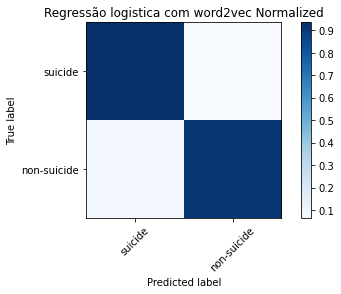

In [37]:
cm = evaluate_prediction(y_pred, np.array(test_targets), "Regressão logistica com word2vec")

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

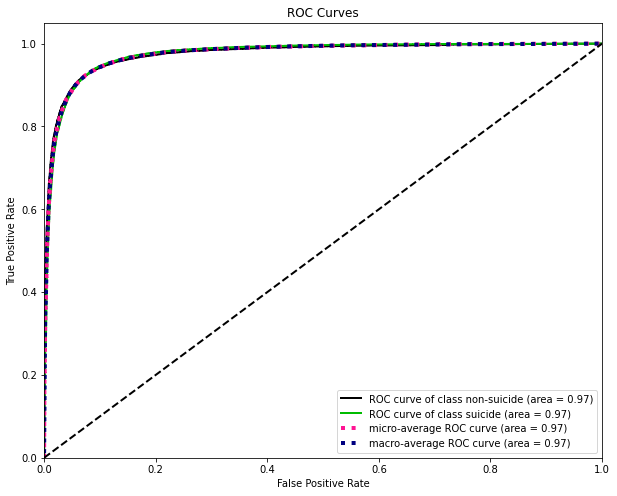

In [38]:
import scikitplot as skplt
skplt.metrics.plot_roc(test_targets, y_score, figsize=(10, 8))

Em uma curva Receiver Operating Characteristic (ROC), a taxa de verdadeiro positivo (Sensibilidade) é traçada em função da taxa de falsos positivos (100-especificidade) para diferentes pontos de corte. Cada ponto na curva ROC representa um par de sensibilidade / especificidade correspondente a um determinado limite de decisão. Um teste com discriminação perfeita (sem sobreposição nas duas distribuições) possui uma curva ROC que passa pelo canto superior esquerdo (100% de sensibilidade, 100% de especificidade). Portanto, quanto mais próxima a curva ROC estiver do canto superior esquerdo, maior será a precisão geral do teste (Zweig & Campbell, 1993).

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

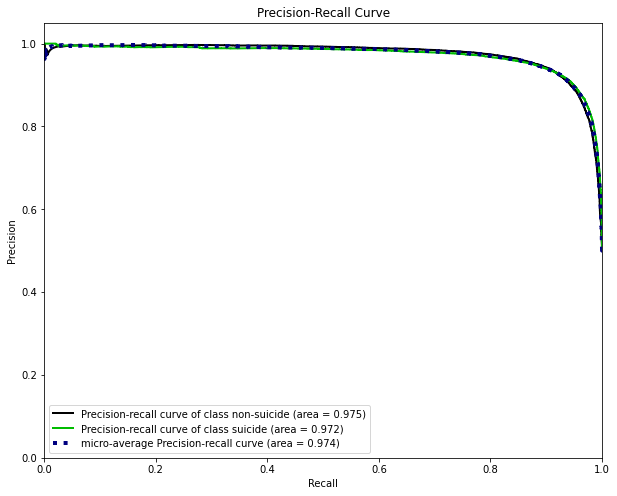

In [39]:
skplt.metrics.plot_precision_recall(test_targets, y_score, figsize=(10, 8))

A precision-recall curve mostra a compensação entre precisão e recuperação para diferentes limites. Uma área alta sob a curva representa alta recuperação e alta precisão, onde alta precisão se relaciona a uma taxa baixa de falsos positivos e alta recuperação se relaciona a uma baixa taxa de falsos negativos. Altas pontuações para ambos mostram que o classificador está retornando resultados precisos (alta precisão), bem como retornando a maioria de todos os resultados positivos (alta recuperação).

Os graficos de Curva ROC e Precisão-Recall demostram uma grande capacidade do modelo rotular todas as instâncias corretamente.

## Preparação dos dados de validação para aplicação do algorítmo

In [40]:
# Divisão dos dados em X e Y

X_validacao = dados_validacao.loc[:, dados_validacao.columns != 'class']
Y_validacao = dados_validacao['class']

In [41]:
def read_valid_data(filename):
    """
    Extrai as postagens dos dados de validação e efetua o pré-processamento usando a biblioteca nltk python
    """
    valid_data = {}
    for i in tqdm(range(filename.shape[0])):
        text_string = filename[i, 0]
        text_string = text_string.lower()
        """ Limpeza do texto"""
        text_string = ''.join(c for c in text_string if not c.isdigit())
        text_string = replace_contractions(text_string) 
        tokenizer = RegexpTokenizer(r'\w+')
        text_string = tokenizer.tokenize(text_string)
        # Atribui a classe aos arquivos
        """ Atribui a relação ao documento """
        valid_data[str(i)] = text_string
    print('\tConcluída a leitura de dados de validação\n') 
               
    return valid_data

In [42]:
valid_words = read_valid_data(np.array(dados_validacao))

100%|██████████| 34811/34811 [00:11<00:00, 3018.78it/s]

	Concluída a leitura de dados de validação



In [43]:
# Processando dados de validação

valid_data = {}
    
print('Construindo o dataset de validação para a postagem\n')
for k,v in tqdm(valid_words.items()):
    valid_data[k] = build_dataset_with_existing_dictionary(valid_words[k],dictionary)

  5%|▌         | 1805/34811 [00:00<00:01, 18045.97it/s]

Construindo o dataset de validação para a postagem



100%|██████████| 34811/34811 [00:01<00:00, 27235.50it/s]


In [44]:
# Converte de Dicionário para lista
data_valid = [ [k,v] for k, v in valid_data.items() ]
data_valid = np.array(data_valid)

In [45]:
data_valid = prepara_dados(data_valid)

In [46]:
X_valid = label_sentences(data_valid[1], data_valid[0])

## Construindo os Vetores de Recurso para o Classificador

In [47]:
%%time

# Dados de validação

valid_targets, valid_regressors = zip(
    *[(doc.tags[0], model_dbow.infer_vector(doc.words, alpha=0.1, min_alpha=0.005, epochs=100)) for doc in tqdm(X_valid)])

100%|██████████| 34811/34811 [07:00<00:00, 82.81it/s]

CPU times: user 6min 56s, sys: 1.28 s, total: 6min 57s
Wall time: 7min


In [48]:
# Excluíndo o dicionário
del dictionary

In [49]:
y_pred = logreg.predict(valid_regressors)
y_score = logreg.predict_proba(valid_regressors)

In [50]:
print('accuracy %s' % accuracy_score(y_pred, Y_validacao))
print(classification_report(Y_validacao, y_pred,target_names=topics))

accuracy 0.9222084973140674
              precision    recall  f1-score   support

     suicide       0.93      0.91      0.92     17510
 non-suicide       0.91      0.93      0.92     17301

    accuracy                           0.92     34811
   macro avg       0.92      0.92      0.92     34811
weighted avg       0.92      0.92      0.92     34811



accuracy 0.9222084973140674
confusion matrix
 [[16134  1167]
 [ 1541 15969]]
(row=expected, col=predicted)


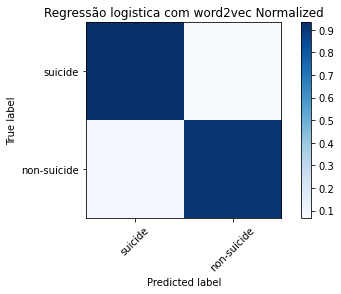

In [51]:
cm = evaluate_prediction(y_pred, np.array(Y_validacao), "Regressão logistica com word2vec")

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

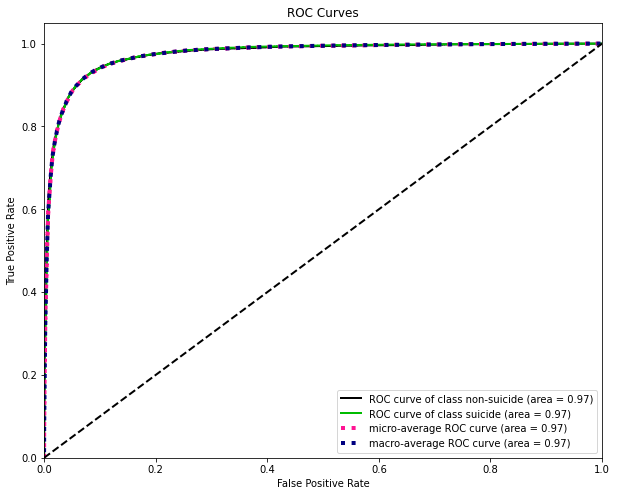

In [52]:
skplt.metrics.plot_roc(Y_validacao, y_score, figsize=(10, 8))

<AxesSubplot:title={'center':'Precision-Recall Curve'}, xlabel='Recall', ylabel='Precision'>

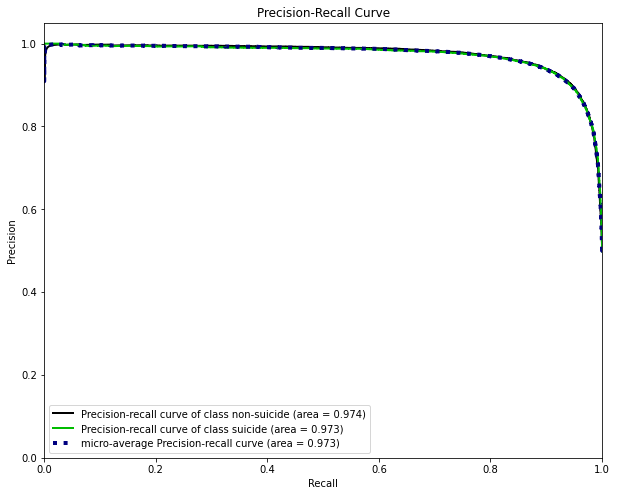

In [53]:
skplt.metrics.plot_precision_recall(Y_validacao, y_score, figsize=(10, 8))

Os graficos de Curva ROC e Precisão-Recall demostram uma grande capacidade do modelo rotular todas as instâncias corretamente.

## Cohen Kappa

O Cohen kappa é uma métrica frequentemente usada para avaliar a concordância entre dois avaliadores. Também pode ser usado para avaliar o desempenho de um modelo de classificação, como muitas outras métricas de avaliação, o Cohen kappa é calculado com base na matriz de confusão.

Landis e Koch (1977) classificam os diferentes níveis de concordância
(ou reprodutibilidade), o Kappa varia de 0 a 1, conforme mostra tabela abaixo:


      Valores de Kappa    Interpretação
           < 0            Ausência de concordância
         0 - 0.20         Concordância mínima
      0.21 - 0.40         Concordância razoável
      0.41 - 0.60         Concordância moderada
      0.61 - 0.80         Concordância substancial
      0.81 - 1.00         Concordância quase perfeita

A estatística kappa é freqüentemente usada como uma medida de confiabilidade entre dois avaliadores humanos. No aprendizado de máquina supervisionado, um "avaliador" reflete a verdade básica, ou seja, os valores reais de cada instância a ser classificada, obtidos a partir de dados rotulados, e o outro "avaliador" é o classificador de aprendizado de máquina usado para realizar a classificação.

In [54]:
# Aplicando o Estatística Kappa
cohen_kappa = cohen_kappa_score(Y_validacao, y_pred)

In [55]:
cohen_kappa

0.8444314564776645

##### Conclusão 
Nosso modelo obteve um score Kappa de 0,85, de acordo a tabela, isso significa que há uma concordância quase perfeita entre a classificação realizada pelo modelo e a classificação relacionada as postagens dos subreddits da plataforma Reddit, demonstrando que o modelo atingiu uma execelnete capacidade de classificar corretamente as postagens com comentários de pessoas com potencial tendencia ao suicídio.

# Fim

## Referencias

[Curso de Processamento de Linguagem Natural e Reconhecimento de Voz da Formação Inteligência Artificial - Datascienceacademy](https://www.datascienceacademy.com.br)

[Gemsin](https://radimrehurek.com/gensim/models/keyedvectors.html)

[Distributed Representations of Words and Phrases and their Compositionality](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)

[Distributed Representations of Sentences and Documents](https://cs.stanford.edu/~quocle/paragraph_vector.pdf)

[A gentle introduction to Doc2Vec](https://medium.com/scaleabout/a-gentle-introduction-to-doc2vec-db3e8c0cce5e)

[Gensim Doc2Vec Tutorial on the IMDB Sentiment Dataset](https://github.com/RaRe-Technologies/gensim/blob/3c3506d51a2caf6b890de3b1b32a8b85f7566ca5/docs/notebooks/doc2vec-IMDB.ipynb)

[Document classification with word embeddings tutorial](https://github.com/RaRe-Technologies/movie-plots-by-genre/blob/master/ipynb_with_output/Document%20classification%20with%20word%20embeddings%20tutorial%20-%20with%20output.ipynb)

[Using Deep Learning for End to End Multiclass Text Classification](https://lionbridge.ai/articles/using-deep-learning-for-end-to-end-multiclass-text-classification/)

[Extracting Information from Text](https://www.nltk.org/book/ch07.html)
